<a href="https://colab.research.google.com/github/google/jax-md/blob/nvt_refactor/notebooks/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#@title Imports & Utils
!pip install -q git+https://www.github.com/deepmind/haiku
!pip install -q --upgrade git+https://www.github.com/google/jax-md

# Imports

import os
import numpy as onp
import pickle

import jax
from jax import lax

from jax.api import jit, vmap, grad

# TODO: Re-enable x64 mode after XLA bug fix.
# from jax.config import config ; config.update('jax_enable_x64', True)
import warnings
warnings.simplefilter('ignore')
import jax.numpy as np

from jax import random
from jax.experimental import optix

from jax_md import energy, space, simulate, quantity

# Plotting.

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
from IPython import display
from functools import partial
  
sns.set_style(style='white')
sns.set(font_scale=1.6)

def format_plot(x, y):
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_facecolor('white')
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def draw_training(params):
  display.clear_output(wait=True)
  display.display(plt.gcf())
  plt.subplot(1, 2, 1)
  plt.semilogy(train_energy_error)
  plt.semilogy(test_energy_error)
  plt.xlim([0, train_epochs])
  format_plot('Epoch', '$L$')
  plt.subplot(1, 2, 2)
  predicted = vectorized_energy_fn(params, example_positions)
  plt.plot(example_energies, predicted, 'o')
  plt.plot(np.linspace(-400, -300, 10), np.linspace(-400, -300, 10), '--')
  format_plot('$E_{label}$', '$E_{prediction}$')
  finalize_plot((2, 1))
  plt.show()

# Data Loading.

def MD_trajectory_reader(f, no_skip=20):
  filename = os.path.join('Supplementary/', f)
  fo = open(filename, 'r')
  samples = fo.read().split('iter= ')[1:]
  steps = []
  lattice_vectors = []
  positions = []
  forces = []
  temperatures = []
  energies = []
  for sample in samples[::no_skip]:
    entries = sample.split('\n')
    steps.append(int(entries[0]))
    lattice_vectors.append(onp.array([list(map(float, lv.split())) for lv in entries[1:4]]))
    assert entries[4]=='64'
    temp = onp.array([list(map(float, lv.split()[1:])) for lv in entries[5:69]])
    positions.append(temp[:,:3])
    forces.append(temp[:,3:])
    remaining_lines = entries[69:]
    temperatures.append(float([entry for entry in entries[69:] if 'Temp' in entry ][0].split('=')[1].split()[0]))
    energies.append(float([entry for entry in entries[69:] if 'el-ion E' in entry ][0].split('=')[1].split()[0]))
  assert (len(set(steps))-(steps[-1]-steps[0]+1)/no_skip) < 1
  return np.array(positions), np.array(energies), np.array(forces)

def build_dataset():
  no_skip = 15
  data300, energies300, forces300 = MD_trajectory_reader(
      'MD_DATA.cubic_300K', no_skip=no_skip)
  data600, energies600, forces600 = MD_trajectory_reader(
      'MD_DATA.cubic_600K', no_skip=no_skip)
  data900, energies900, forces900 = MD_trajectory_reader(
      'MD_DATA.cubic_900K', no_skip=no_skip)
  dataliq, energiesliq, forcesliq = MD_trajectory_reader(
      'MD_DATA.liq_1', no_skip=no_skip)

  all_data = np.vstack((data300, data600, data900))
  all_energies = np.hstack((energies300, energies600, energies900))
  all_forces = np.vstack((forces300, forces600, forces900))
  noTotal = all_data.shape[0]

  onp.random.seed(0)
  II = onp.random.permutation(range(noTotal))
  all_data = all_data[II]
  all_energies = all_energies[II]
  all_forces = all_forces[II]
  noTr = int(noTotal * 0.65)
  noTe = noTotal - noTr
  train_data = all_data[:noTr]
  test_data = all_data[noTr:]

  train_energies = all_energies[:noTr]
  test_energies = all_energies[noTr:]

  train_forces = all_forces[:noTr]
  test_forces = all_forces[noTr:]

  return ((train_data, train_energies, train_forces),
          (test_data, test_energies, test_forces))

# Neural Network Potentials

An area of significant recent interest is the use of neural networks to model quantum mechanics. Since directly (or approximately) solving Schrodinger's equation is extremely expensive, these techniques offers the tantalizing possibility of conducting large-scale and high-fidelity experiments of materials as well as chemical and biochemical systems. 

\

Usually, neural networks are fit to energies computed from Density Functional Theory (DFT). DFT is a ubiquitous *ab initio* formalism for approximating solutions to Schrodinger's equation. It offers a balance between accuracy and speed; DFT is much faster than more precise solutions to quantum systems, but is fast enough to use on systems of hundreds of atoms. Nonetheless, DFT calculations scale as $\mathcal O(N^3)$ and so they are prohibitively expensive to run on large systems or for long simulation trajectories. 

\

As with many areas of machine learning, early efforts to fit quantum mechanical interactions with neural networks relied on fixed feature methods with shallow neural network potentials. Lately, however, these networks have been replaced by deeper graph neural network architectures that learn salient features. JAX MD includes both popular fixed-feature methods as well as graph neural networks. 

\

Here we will use JAX MD to fit a state-of-the-art graph neural network to open-source DFT data from a 64-atom Silicon system that accompanied a [recent paper](https://aip.scitation.org/doi/10.1063/1.4990503). This Silicon system was simulated at several different temperatures. We will uniformly sample data from these trajectories to construct training and test sets. We will follow modern best-practices and fit to both energies and forces computed using DFT. We will then use this network to run a simulation using JAX MDs simulation environments. To start with we first download the data. This might take a little a minute or two.

In [ ]:
#@title Download Data

!wget https://aip.scitation.org/doi/suppl/10.1063/1.4990503/suppl_file/supplementary.zip
!wget https://github.com/google/jax-md/blob/master/examples/models/si_gnn.pickle?raw=true
!unzip supplementary.zip

We will then load the data using a small utility function into training and test sets. Each split will include particle positions, whole-system energies, and per-particle forces. To assist in training we will compute the mean and standard deviation of the data and use this to set the initial scale for our neural network.

In [ ]:
train, test = build_dataset()

positions, energies, forces = train
test_positions, test_energies, test_forces = test

energy_mean = np.mean(energies)
energy_std = np.std(energies)

print('positions.shape = {}'.format(positions.shape))
print('<E> = {}'.format(energy_mean))

positions.shape = (2416, 64, 3)
<E> = -368.9131164550781


Next we create a space for our systems to live in using `periodic` boundary conditions.

In [ ]:
box_size = 10.862  # The size of the simulation region.
displacement, shift = space.periodic(box_size)

We can now instantiate a graph neural network using the `energy.graph_network_neighbor_list` command. This neural network is based on [recent work](https://www.nature.com/articles/s41567-020-0842-8) modelling defects in disordered solids. See that paper or the review by [Battaglia et al.](https://arxiv.org/abs/1806.01261) for details. We will add edges between all neighbors that are separated by less than a cutoff of 3 Angstroms. In JAX MD neural network potentials are specified by a triple of functions: a `neighbor_fn` that creates a list of neighbors that reside within the cutoff, an `init_fn` that initializes the parameters of the network, and an `energy_fn` that evaluates the model.

In [ ]:
neighbor_fn, init_fn, energy_fn = energy.graph_network_neighbor_list(
    displacement, box_size, r_cutoff=3.0, dr_threshold=0.0)

To start with, we construct an initial neighbor list which will be used to estimate the maximum number of neighbors. This is necessary since XLA needs to have static shapes to enable JIT compilation. See [here](https://github.com/google/jax-md#spatial-partitioning-partitionpy) for details.

In [ ]:
neighbor = neighbor_fn(positions[0], extra_capacity=6)

print('Allocating space for at most {} neighbors'.format(neighbor.idx.shape[1]))

Allocating space for at most 14 neighbors


Using this neighbor prototype we will write a wrapper around our neural network energy function that will construct a neighbor list for a given state and then compute the energy. This is helpful because it allows us to use JAX's automatic vectorization via `vmap` along with our neighbor lists. Using JAX's automatic differentiation we can also write down a function that computes the force due to our neural network potential.

Note that if we were running a simulation using this energy, we would only rebuild the neighbor list when necessary.

In [ ]:
@jit
def train_energy_fn(params, R):
  _neighbor = neighbor_fn(R, neighbor)
  return energy_fn(params, R, _neighbor)

# Vectorize over states, not parameters.
vectorized_energy_fn = vmap(train_energy_fn, (None, 0))

grad_fn = grad(train_energy_fn, argnums=1)
force_fn = lambda params, R, **kwargs: -grad_fn(params, R)
vectorized_force_fn = vmap(force_fn, (None, 0))

Next we will initialize the parameters of the graph network. This is done by providing the `init_fn` with a random key as well as an example input. As with the neighbor lists, this example input is used to deduce the shape of the various parameters.

In [ ]:
key = random.PRNGKey(0)

params = init_fn(key, positions[0], neighbor)

Now, we can use JAX's automatic vectorization via `vmap` to compute predicted energies for all of the states using the untrained network.

In [ ]:
n_predictions = 500
example_positions = positions[:n_predictions]
example_energies = energies[:n_predictions]
example_forces = forces[:n_predictions]

predicted = vmap(train_energy_fn, (None, 0))(params, example_positions)

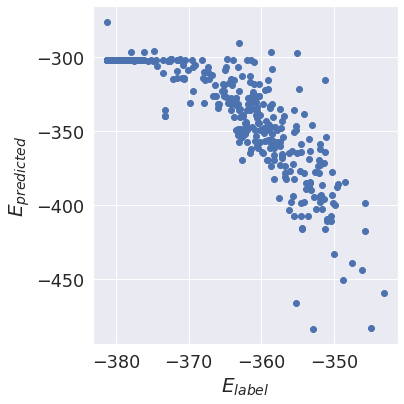

In [ ]:
plt.plot(example_energies, predicted, 'o')

format_plot('$E_{label}$', '$E_{predicted}$')

finalize_plot((1, 1))

Despite the fact that the neural network is untrained we see that the outputs of the graph network correlate strongly with the labels. This hints that perhaps graph networks provide some sort of "deep molecular prior". 

Next, we define losses for the energy and the force as well as a total loss that combines the two terms. We fit both the force and the energy using Mean-Squared-Error (MSE) loss.

In [ ]:
@jit
def energy_loss(params, R, energy_targets):
  return np.mean((vectorized_energy_fn(params, R) - energy_targets) ** 2)

@jit
def force_loss(params, R, force_targets):
  dforces = vectorized_force_fn(params, R) - force_targets
  return np.mean(np.sum(dforces ** 2, axis=(1, 2)))

@jit
def loss(params, R, targets):
  return energy_loss(params, R, targets[0]) + force_loss(params, R, targets[1])

Now we create an optimizer using ADAM with gradient clipping. We will also write helper functions to perform a single update step and perform an entire epochs worth of updates.

In [ ]:
opt = optix.chain(optix.clip_by_global_norm(1.0),
                  optix.adam(1e-3))

@jit
def update_step(params, opt_state, R, labels):
  updates, opt_state = opt.update(grad(loss)(params, R, labels),
                                  opt_state)
  return optix.apply_updates(params, updates), opt_state

@jit
def update_epoch(params_and_opt_state, batches):
  def inner_update(params_and_opt_state, batch):
    params, opt_state = params_and_opt_state
    b_xs, b_labels = batch

    return update_step(params, opt_state, b_xs, b_labels), 0
  return lax.scan(inner_update, params_and_opt_state, batches)[0]

Finally, we will write a function that creates an epoch's worth of batches given a lookup table that shuffles all of the states in the training set.

In [ ]:
dataset_size = positions.shape[0]
batch_size = 128

lookup = onp.arange(dataset_size)
onp.random.shuffle(lookup)

@jit
def make_batches(lookup):
  batch_Rs = []
  batch_Es = []
  batch_Fs = []

  for i in range(0, len(lookup), batch_size):
    if i + batch_size > len(lookup):
      break

    idx = lookup[i:i + batch_size]

    batch_Rs += [positions[idx]]
    batch_Es += [energies[idx]]
    batch_Fs += [forces[idx]]

  return np.stack(batch_Rs), np.stack(batch_Es), np.stack(batch_Fs)

batch_Rs, batch_Es, batch_Fs = make_batches(lookup)

We're now ready to train our network. We'll start by training for twenty epochs to make sure it starts training.

<Figure size 432x288 with 0 Axes>

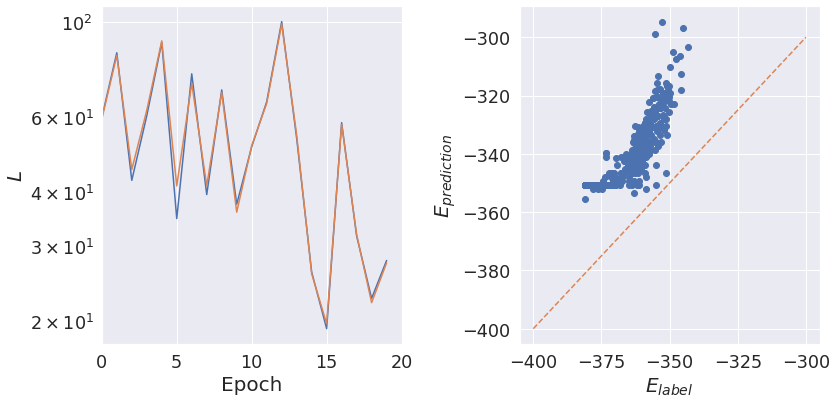

In [ ]:
train_epochs = 20

opt_state = opt.init(params)

train_energy_error = []
test_energy_error = []

for iteration in range(train_epochs):
  train_energy_error += [float(np.sqrt(energy_loss(params, batch_Rs[0], batch_Es[0])))]
  test_energy_error += [float(np.sqrt(energy_loss(params, test_positions, test_energies)))]
 
  draw_training(params)

  params, opt_state = update_epoch((params, opt_state), 
                                   (batch_Rs, (batch_Es, batch_Fs)))

  onp.random.shuffle(lookup)
  batch_Rs, batch_Es, batch_Fs = make_batches(lookup)

While we see that the network has begun to learn the energies, we also see that it has a long way to go before the predictions get good enough to use in a simulation. As such we're going to take inspiration from cooking shows, and take a ready-made GNN out of the fridge where it has been training overnight for 12,000 epochs on a V100 GPU.

In [ ]:
with open('si_gnn.pickle?raw=true', 'rb') as f:
  params = pickle.load(f)

Using our trained model we plot the predicted energies and forces against the labels. 

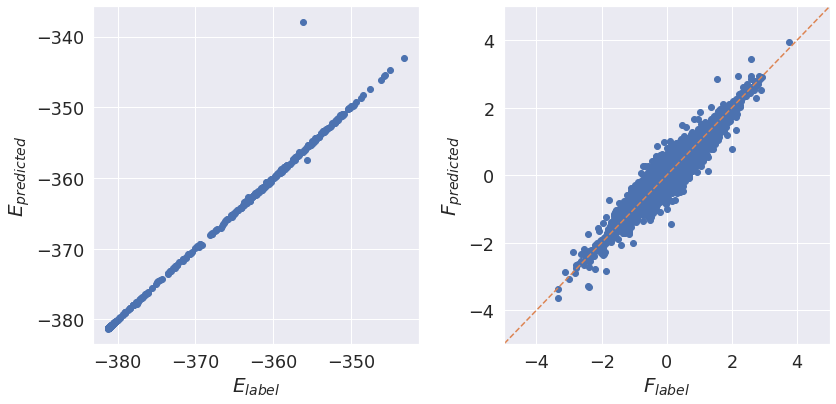

In [ ]:
plt.subplot(1, 2, 1)

predicted_energies = vectorized_energy_fn(params, example_positions)
plt.plot(example_energies, predicted_energies, 'o')

format_plot('$E_{label}$', '$E_{predicted}$')
plt.subplot(1, 2, 2)

predicted_forces = vectorized_force_fn(params, test_positions[:300])
plt.plot(test_forces[:300].reshape((-1,)),
         predicted_forces.reshape((-1,)), 
         'o')
plt.plot(np.linspace(-6, 6, 20), np.linspace(-6, 6, 20), '--')
plt.xlim([-5, 5])
plt.ylim([-5, 5])

format_plot('$F_{label}$', '$F_{predicted}$')
finalize_plot((2, 1))

We see that the model prediction for the energy is extremely accurate and the force prediction is reasonable. To make this a bit more quantitative, we can compute the RMSE of the energy and convert it to meV / atom.

In [ ]:
rmse = energy_loss(params, test_positions, test_energies) * 1000 / 64
print('RMSE Error of {:.02f} meV / atom'.format(rmse))

RMSE Error of 9.03 meV / atom


We see that we get an error of about $2$ meV / atom, which is comparable to previous work on this system.

Now that we have a well-performing neural network, we can see how easily this network can be used to run a simulation approximating Silicon. We will run a constant temperature simulation using a Nose-Hoover thermostat. First, we "bake" the params into the energy function using partial evaluation.

In [ ]:
E_fn = partial(energy_fn, params)

Then, we setup the parameters of the simulation and create the simulation environment.

In [ ]:
K_B = 8.617e-5
dt = 1e-3
kT = K_B * 300 
Si_mass = 2.91086E-3

init_fn, apply_fn = simulate.nvt_nose_hoover(E_fn, shift, dt, kT)

apply_fn = jit(apply_fn)

Finally we run the simulation for 10000 steps while writing the energy and temperature throughout.

In [ ]:
# Define the simulation.
total_steps = 10000
steps_per_recording = 25
total_records = total_steps // steps_per_recording

positions = []

@jit
def sim(state, nbrs):
  def step(i, state_nbrs):
    state, nbrs = state_nbrs
    nbrs = neighbor_fn(state.position, nbrs)
    return apply_fn(state, neighbor=nbrs), nbrs
  return lax.fori_loop(0, steps_per_recording, step, (state, nbrs))


# Initialize the simulation

state = init_fn(key, test_positions[0], Si_mass)
nbrs = neighbor_fn(state.position)


# Run the simulation.

print('Energy (eV)\tTemperature (K)')
for i in range(total_records):
  state, nbrs = sim(state, nbrs)

  positions += [state.position]

  if i % 40 == 0:
    print('{:.02f}\t\t\t{:.02f}'.format(
        E_fn(state.position, neighbor=nbrs),
        quantity.temperature(state.velocity, Si_mass) / K_B))

positions = np.stack(positions)

Energy (eV)	Temperature (K)
-374.17			332.67
-378.06			310.34
-378.75			293.12
-378.78			291.41
-378.05			353.56
-378.21			284.94
-378.84			278.45
-378.33			369.94
-378.14			282.23
-378.43			365.53


We see that the energy of the simulation is reasonable and the temperature is stable. Of course, if we were validating this model for use in a research setting there are many measurements that one would like to perform to check its fidelity.

We can now draw the simulation to see what is happening.

In [ ]:
from jax_md.colab_tools import renderer

nbrs = neighbor_fn(state.position)

renderer.render(box_size,
                {
                    'atom': renderer.Sphere(positions),
                    'bonds': renderer.Bond('atom', nbrs.idx),
                },
                resolution=[512, 512])